<a href="https://colab.research.google.com/github/TrineSiewEngelund/Scandeemotion/blob/main/Scandeemotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Scandeemotion 🎭 🇳🇴🇸🇪🇩🇰

###This notebook contains the code for my free topic on fine-tuning a BERT for Emotion Analysis in the three Scandinavian languages, Danish, Norwegian, and Swedish.

Trine K. M. Siewartz Engelund

lcz713@alumni.ku.dk

-------
In this notebook, we will:


1.  Install libraries
2.  Read and preprocess the dataset
3.  Load pre-trained BERT model and set arguments
4.  Define etrics for evalution during training
3.  Fine-tune BERT
4.  Evaluate and plot performance

Before we start, check that GPU is enabled (click on the “Runtime” tab, select “change runtime type”, and select "GPU" as the type of hardware accelerator. Finally, click “save”).

Now we are all set and ready to start!

___________


## Install libraries

First, we have to install the necessary libraries.



In [ ]:
!pip install transformers
!pip install simpletransformers
!pip install wandb
import wandb
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from simpletransformers.classification import MultiLabelClassificationModel
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.1 MB/s 
     |████████████████████████████████| 182 kB 45.2 MB/s 
     |████████████████████████████████| 7.6 MB 42.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 250 kB 27.8 MB/s 
     |████████████████████████████████| 9.2 MB 64.3 MB/s 
     |████████████████████████████████| 1.3 MB 66.2 MB/s 
     |████████████████████████████████| 1.9 MB 61.5 MB/s 
     |████████████████████████████████| 452 kB 50.5 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 174 kB 70.8 MB/s 
     |████████████████████████████████| 184 kB 72.7 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 173 kB 76.7 MB/s 
     |████████████████████████████████| 168 kB 75.5 M

If you wish to visualize the fine-tuning, you must log in and authenticate to your Weights & Biases (wandb) account. Otherwise, this step can be skipped. Note, you must have created a user beforehand.

In [ ]:
!wandb login

wandb: Currently logged in as: trinesieweng. Use `wandb login --relogin` to force relogin


## Dataset

Next, we will read the dataset. The dataset origins from the XED dataset.

Reference:
Öhman, E., Pàmies, M., Kajava, K. and Tiedemann, J., 2020. XED: A Multilingual Dataset for Sentiment Analysis and Emotion Detection. In Proceedings of the 28th International Conference on Computational Linguistics (COLING 2020).
https://github.com/Helsinki-NLP/XED

I have to execute the cell below and upload the three provided tsv files, *da-projections.tsv*, *no-projections.tsv*, and *sv-projections.tsv*

(If you are using Safari as a browser, you may have some problems uploading the files. If you do so, you can upload the files in the panel on the left)

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# read Danish, Norwegian and Swedish data from XED
data_da = pd.read_csv('da-projections.tsv', sep='\t', header=None, names=['text', 'labels'])
data_no = pd.read_csv('no-projections.tsv', sep='\t', header=None, names=['text', 'labels'])
data_sv = pd.read_csv('sv-projections.tsv', sep='\t', header=None, names=['text', 'labels'])

# concat data
data = pd.concat([data_da,data_no,data_sv])

# add language label
language = ['danish'] * len(data_da) + ['norwegian'] * len(data_no) + ['swedish'] * len(data_sv)
data["language"] = language

# format labels from string to list
data.labels = [[int(idx, 16) for idx in x.split(",")] for x in data['labels']]

# reset index
data = data.reset_index(drop=True)


Let's plot the distribution of emotions and languages

In [ ]:
df = data.explode(column="labels")
da = df[df["language"]=="danish"]["labels"].value_counts().sort_index()
no = df[df["language"]=="norwegian"]["labels"].value_counts().sort_index()
sv = df[df["language"]=="swedish"]["labels"].value_counts().sort_index()
emotions=['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

fig = go.Figure(data=[
    go.Bar(name='Danish', x=emotions, y=da, marker_color="midnightblue"),
    go.Bar(name='Norwegian', x=emotions, y=no, marker_color="deepskyblue"),
    go.Bar(name='Swedish', x=emotions, y=sv, marker_color="skyblue")
])

fig.update_layout(barmode='stack')
fig.show()

We have to one-hot-encode the labels

In [ ]:
# The one_hot_encoder() function origins from a Medium tutorial: "Multi-label Emotion Classification with PyTorch + HuggingFace’s Transformers and W&B for Tracking"
# Link: https://medium.com/towards-data-science/multi-label-emotion-classification-with-pytorch-huggingfaces-transformers-and-w-b-for-tracking-a060d817923

def one_hot_encoder(df):
    one_hot_encoding = []
    for i in range(len(df)):
        temp = [0]*9
        label_indices = df.iloc[i]["labels"]
        for index in label_indices:
            temp[index] = 1
        one_hot_encoding.append(temp)
    return pd.DataFrame(one_hot_encoding)

In [ ]:
data_ohe_labels = one_hot_encoder(data)
data = pd.concat([data, data_ohe_labels], axis=1)
del data["labels"]
data["labels"] = data[[0,1,2,3,4,5,6,7,8]].values.tolist()
new_df = data[["text", "labels", "language"]]

Finally, we split the dataset in train, develop and test set

In [ ]:
# split in train, develop and test set
train_df, eval_test_df = train_test_split(new_df, test_size=0.3, random_state=42, shuffle=True)
eval_df, test_df = train_test_split(eval_test_df, test_size=0.5, random_state=42, shuffle=True)

## Load pre-trained model and set args

Here, we define the model type and set the arguments

More configuration options can be found here: https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model

In [ ]:
model = MultiLabelClassificationModel(model_type="bert",
                                      model_name="NbAiLab/nb-bert-base",
                                      num_labels=9,
                                      args={'train_batch_size': 8,
                                            'eval_batch_size': 8,
                                            'logging_steps': 10,
                                            'evaluate_during_training': True,
                                            'evaluate_during_training_steps': 1000,
                                            'save_eval_checkpoints': False,
                                            'learning_rate': 0.00003,
                                            'num_train_epochs': 35, # since we use early stopping, epochs are not that important
                                            'scheduler': 'cosine_schedule_with_warmup',
                                            'fp16': True,
                                            'wandb_project': "free_topic", # name of project in Weights & Biases
                                        
                                            # threshold
                                            'threshold': 0.5,

                                            # early stopping
                                            'use_early_stopping': True,
                                            'early_stopping_metric': 'f1_micro',
                                            'early_stopping_metric_minimize': False,
                                            'early_stopping_delta': 0.01,

                                            # some args to prevent disk overload on Google Colab
                                            'save_steps': -1,
                                            'save_model_every_epoch': False,
                                            'overwrite_output_dir': True
                                            })


Downloading:   0%|          | 0.00/746 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at NbAiLab/nb-bert-base were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLa

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

##Metrics for evalution during training

Wrapper functions for evaluation

In [ ]:
# predictions to one-hot-encodings
def pred_to_ohe(pred):
    if pred >= 0.5: #if prediction is over threshold
        return 1
    else:
      return 0

In [ ]:
# f1 micro
def f1_micro(labels, predictions):
  preds = [[pred_to_ohe(pred) for pred in row] for row in predictions]
  return f1_score(labels, preds, average="micro")

In [ ]:
# f1 macro
def f1_macro(labels, predictions):
  preds = [[pred_to_ohe(pred) for pred in row] for row in predictions]
  return f1_score(labels, preds, average="macro", zero_division=0)

In [ ]:
# precision
def precision(labels, predictions):
  preds = [[pred_to_ohe(pred) for pred in row] for row in predictions]
  return precision_score(labels, preds, average="micro", zero_division=0)

In [ ]:
# recall
def recall(labels, predictions):
  preds = [[pred_to_ohe(pred) for pred in row] for row in predictions]
  return recall_score(labels, preds, average="micro", zero_division=0)

## Fine-tuning

And now for the fun part: fine-tuning!

Find your project at Weights & Biases' website to follow your model's performance while training.

In [ ]:
model.train_model(train_df, eval_df=eval_df, f1_micro=f1_micro, f1_macro=f1_macro, precision=precision, recall=recall)

If you wish to save your fine-tuned model in Google Drive, you can connect in the cell below.

When connected, go to the left panel and drag the "outputs" folder to your Drive folder.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Evaluate

Now we will evaluate the performance of the fine-tuned BERT.

You can uncomment the cell below if you want to evaluate a previous fine-tuned model. Otherwise, you can ignore it.

In [ ]:
# uncomment the line below, if using a previous model
model = MultiLabelClassificationModel("bert", "gdrive/MyDrive/outputs4/best_model")

In [ ]:
# test data for Danish, Norwegian, and Swedish
test_df_da = test_df[test_df["language"]=="danish"]
test_df_no = test_df[test_df["language"]=="norwegian"]
test_df_sv = test_df[test_df["language"]=="swedish"]

In [ ]:
# compute predictions on eval set
# all
result_eval, model_outputs_eval, wrong_preds_eval = model.eval_model(eval_df)

# compute predictions on test set
# all
result, model_outputs, wrong_preds = model.eval_model(test_df)

# danish
result_da, model_outputs_da, wrong_preds_da = model.eval_model(test_df_da)

# norwegian
result_no, model_outputs_no, wrong_preds_no = model.eval_model(test_df_no)

# swedish
result_sv, model_outputs_sv, wrong_preds_sv = model.eval_model(test_df_sv)

  0%|          | 0/1650 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/1651 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/728 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/91 [00:00<?, ?it/s]

In [ ]:
# compute performance on eval set
# all
predictions_eval = [[pred_to_ohe(pred) for pred in row] for row in model_outputs_eval]
print("--- EVAL SET (ALL) ---")
print("Precision:", precision_score(eval_df["labels"].to_list(), predictions_eval, average="micro"))
print("Recall:", recall_score(eval_df["labels"].to_list(), predictions_eval, average="micro"))
print("F1 micro:", f1_score(eval_df["labels"].to_list(), predictions_eval, average="micro"))
print("F1 macro:", f1_score(eval_df["labels"].to_list(), predictions_eval, average="macro", zero_division=0))
print("Support:", len(eval_df))

# compute performance on test set
# all
predictions = [[pred_to_ohe(pred) for pred in row] for row in model_outputs]
print("\n--- TEST SET (ALL) ---")
print("Precision:", precision_score(test_df["labels"].to_list(), predictions, average="micro"))
print("Recall:", recall_score(test_df["labels"].to_list(), predictions, average="micro"))
print("F1 micro:", f1_score(test_df["labels"].to_list(), predictions, average="micro"))
print("F1 macro:", f1_score(test_df["labels"].to_list(), predictions, average="macro", zero_division=0))
print("Support:", len(test_df))

# danish
predictions_da = [[pred_to_ohe(pred) for pred in row] for row in model_outputs_da]
print("\n--- TEST SET (DANISH) ---")
print("Precision:", precision_score(test_df_da["labels"].to_list(), predictions_da, average="micro"))
print("Recall:", recall_score(test_df_da["labels"].to_list(), predictions_da, average="micro"))
print("F1 micro:", f1_score(test_df_da["labels"].to_list(), predictions_da, average="micro"))
print("F1 macro:", f1_score(test_df_da["labels"].to_list(), predictions_da, average="macro", zero_division=0))
print("Support:", len(test_df_da))

# norwegian
predictions_no = [[pred_to_ohe(pred) for pred in row] for row in model_outputs_no]
print("\n--- TEST SET (NORWEGIAN) ---")
print("Precision:", precision_score(test_df_no["labels"].to_list(), predictions_no, average="micro"))
print("Recall:", recall_score(test_df_no["labels"].to_list(), predictions_no, average="micro"))
print("F1 micro:", f1_score(test_df_no["labels"].to_list(), predictions_no, average="micro"))
print("F1 macro:", f1_score(test_df_no["labels"].to_list(), predictions_no, average="macro", zero_division=0))
print("Support:", len(test_df_no))

# swedish
predictions_sv = [[pred_to_ohe(pred) for pred in row] for row in model_outputs_sv]
print("\n--- TEST SET (SWEDISH) ---")
print("Precision:", precision_score(test_df_sv["labels"].to_list(), predictions_sv, average="micro"))
print("Recall:", recall_score(test_df_sv["labels"].to_list(), predictions_sv, average="micro"))
print("F1 micro:", f1_score(test_df_sv["labels"].to_list(), predictions_sv, average="micro"))
print("F1 macro:", f1_score(test_df_sv["labels"].to_list(), predictions_sv, average="macro", zero_division=0))
print("Support:", len(test_df_sv))


--- EVAL SET (ALL) ---
Precision: 0.5885350318471337
Recall: 0.5875370919881305
F1 micro: 0.5880356385235469
F1 macro: 0.5102337826360119
Support: 1650

--- TEST SET (ALL) ---
Precision: 0.5933835845896147
Recall: 0.5831275720164609
F1 micro: 0.5882108758821087
F1 macro: 0.5087541567194913
Support: 1651

--- TEST SET (DANISH) ---
Precision: 0.6235294117647059
Recall: 0.6191588785046729
F1 micro: 0.6213364595545134
F1 macro: 0.5332174340900424
Support: 284

--- TEST SET (NORWEGIAN) ---
Precision: 0.5890710382513661
Recall: 0.5871459694989106
F1 micro: 0.5881069285324604
F1 macro: 0.5086289337760421
Support: 639

--- TEST SET (SWEDISH) ---
Precision: 0.5849236641221374
Recall: 0.5654981549815498
F1 micro: 0.5750469043151969
F1 macro: 0.49744981536533367
Support: 728


In [ ]:
# compute performance for each class/emotion

classification_report(
    test_df["labels"].to_list(),
    predictions,
    zero_division=0,
    output_dict=True,
    target_names=['Neutral', 'Anger', 'Anticipation', 'Disgust','Fear', 'Joy', 'Sadness', 'Surprise', 'Trust'])

{'Neutral': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 'Anger': {'precision': 0.6008583690987125,
  'recall': 0.6526806526806527,
  'f1-score': 0.6256983240223464,
  'support': 429},
 'Anticipation': {'precision': 0.6157205240174672,
  'recall': 0.6844660194174758,
  'f1-score': 0.6482758620689656,
  'support': 412},
 'Disgust': {'precision': 0.5789473684210527,
  'recall': 0.39487179487179486,
  'f1-score': 0.4695121951219512,
  'support': 195},
 'Fear': {'precision': 0.5308056872037915,
  'recall': 0.4890829694323144,
  'f1-score': 0.5090909090909091,
  'support': 229},
 'Joy': {'precision': 0.6576271186440678,
  'recall': 0.60625,
  'f1-score': 0.6308943089430893,
  'support': 320},
 'Sadness': {'precision': 0.6265060240963856,
  'recall': 0.5512367491166078,
  'f1-score': 0.5864661654135338,
  'support': 283},
 'Surprise': {'precision': 0.5668016194331984,
  'recall': 0.5243445692883895,
  'f1-score': 0.5447470817120623,
  'support': 267},
 'Trust': {'precis

## Plot performance

In [ ]:
# multilabel confusion matrix
cm = multilabel_confusion_matrix(test_df["labels"].to_list(), predictions, labels=[0,1,2,3,4,5,6,7,8])

In [ ]:
# normalize confusion matrix over true labels
percentages = []
for i in cm:
  for row in i:
    left = np.round(row[0]/(row[0]+row[1]), decimals=3)
    right = np.round(row[1]/(row[0]+row[1]), decimals=3)
    percentages.append(left)
    percentages.append(right)

cm = np.array(percentages).reshape(-1,2,2)[1:] # drop neutral

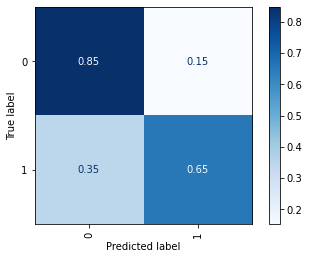

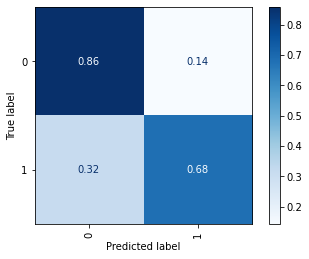

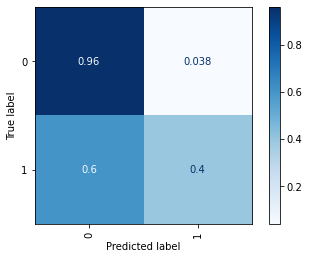

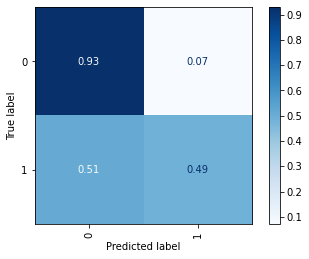

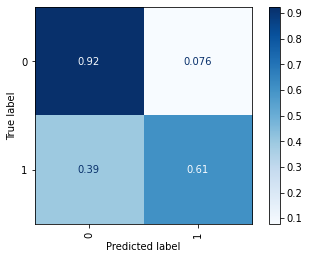

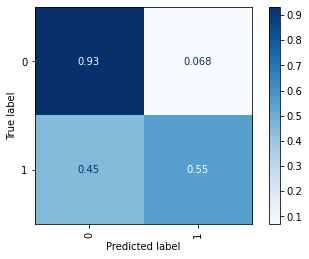

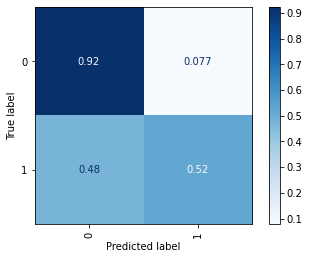

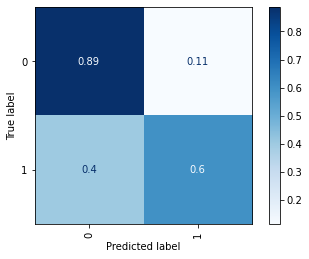

In [ ]:
# plot confusion matrix for each class/emotion
for confusion_matrix in cm:
    disp = ConfusionMatrixDisplay(confusion_matrix)
    disp.plot(include_values=True, cmap="Blues", ax=None, xticks_rotation="vertical")
    plt.show()

## Predict

Here, you can try out the model yourself. Remember, that the predicitions are one-hot-encoded. Here is the correspondence between indices and classes:

*   0: Neutral
*   1: Anger
*   2: Anticipation
*   3: Disgust
*   4: Fear
*   5: Joy
*   6: Sadness
*   7: Surprise
*   8: Trust

Have fun!

In [ ]:
model.predict(['Den lille pige blev overrasket, da hun åbnede sin flot indpakket julegave'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

([[0, 0, 0, 0, 0, 1, 0, 1, 0]],
 array([[3.29613686e-05, 2.39729881e-04, 1.08146667e-03, 3.47375870e-04,
         2.59160995e-04, 9.99511719e-01, 3.62634659e-04, 8.55468750e-01,
         4.10795212e-04]]))